In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from nltk.tokenize import word_tokenize
from torchtext.vocab import build_vocab_from_iterator
import string
import random
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [147]:
class BaseDataset(Dataset):
    def __init__(self, file_path: str, column: str, add_sos_eos: bool=False):
        self.df = pd.read_csv(file_path)
        self.sentences = self.df[column]
        self.vocabs = build_vocab_from_iterator(
            self.token_genarator(self.sentences)
            )
        self.add_sos_eos = add_sos_eos
        if self.add_sos_eos == True:
            extra_tokens = ["<PAD>", "<SOS>", "<EOS>", "<UNK>"]
            for token in extra_tokens:
                self.vocabs.append_token(token)
        else:
            extra_tokens = ["<PAD>", "<UNK>"]
            for token in extra_tokens:
                self.vocabs.append_token(token)

    def token_genarator(self, sentences: str):
        for text in sentences:
            clean_text = "".join(
                [word for word in text 
                 if word not in string.punctuation]
            )
            tokens = word_tokenize(clean_text)
            yield tokens

    def text_to_sequences(self, sentences: str) -> int:
        sequence = [
            self.vocabs[token] if token in self.vocabs
            else self.vocabs["<UNK>"]
            for token in word_tokenize(sentences)
            ]
        if self.add_sos_eos == True:
            sequence = [self.vocabs["<SOS>"]] + sequence + [self.vocabs["<EOS>"]]

        return sequence

    def __len__(self) -> int:
        return len(self.sentences)
    
    def __getitem__(self, index) -> torch.Tensor:
        item = self.sentences[index]
        sequence = self.text_to_sequences(item)
        return torch.tensor(sequence)
    

class CombineDataset(Dataset):
    def __init__(self, data_path, eng_column, ban_column):
        self.eng_data = BaseDataset(
            file_path= data_path,
            column = eng_column, 
            add_sos_eos=True,
        )
        self.bng_data = BaseDataset(
            file_path= data_path,
            column = ban_column,
            add_sos_eos=True
        )

    @staticmethod
    def collate_fn(batch):
        en, bn = zip(*batch)
        # en = [item[0] for item in batch]
        # bn = [item[1] for item in batch]
        en_padded = pad_sequence(en, padding_value=0, batch_first=False)
        bn_padded = pad_sequence(bn, padding_value=0, batch_first=False)
        return en_padded, bn_padded 

    def __len__(self) -> int:
        return len(self.eng_data)
    
    def __getitem__(self, index) -> torch.Tensor:
        eng_item = self.eng_data[index]
        bng_item = self.bng_data[index]
        return eng_item, bng_item

In [148]:
class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, n_layers, dropout_rate, debugging=False):
        super(Encoder, self).__init__()
        self.debugging = debugging
        self.embed_layer = nn.Embedding(input_size, embed_size)
        self.rnn_layer = nn.GRU(embed_size, hidden_size, n_layers, bidirectional=False)
        self.dropout_layer = nn.Dropout(p=dropout_rate)

    def forward(self, source):
        # Apply dropout and get embedding
        embedding = self.dropout_layer(self.embed_layer(source))
        # Unpack RNN
        output, hidden = self.rnn_layer(embedding)

        if self.debugging:
            print("Encoder Embedding Shape", embedding.shape)
            print("Encoder Hidden Shape", hidden.shape)
            print("Encoder Output Shape", output.shape)
            
        return output, hidden

In the Bahdanau attention mechanism, we need to compute a score between the current decoder hidden state (query) and all encoder hidden states (keys). To achieve this, we perform a sum operation between query and keys, but their shapes need to match for this operation to be valid.

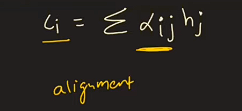

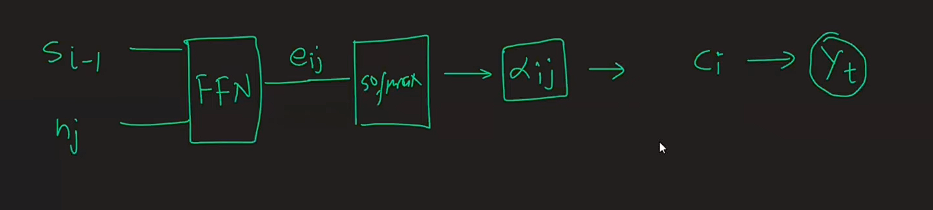

In [149]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size, debugging=False):
        super(BahdanauAttention, self).__init__()
        self.debugging = debugging
        self.hidden_size = hidden_size
        self.W = nn.Linear(hidden_size, hidden_size)
        self.U = nn.Linear(hidden_size, hidden_size)
        self.V = nn.Linear(hidden_size, 1)

    def forward(self, decoder_hidden, encoder_output):
        # decoder hidden shape = (batch_size, hidden_size)
        # encoder output shape = (seq_len, batch_size, hidden_size)
       
        #add an extra dimension to match the query
        decoder_hidden = decoder_hidden.unsqueeze(0)
        #compute attention/alignment score
        score = self.V(F.tanh(self.W(decoder_hidden) + self.U(encoder_output)))
        #compute attention weights
        weights = F.softmax(score)
        #compute the context vector
        context = torch.sum(weights * encoder_output, dim=0)

        if self.debugging:
            print("Encoder Output Shape", encoder_output.shape)
            print("Decoder Hidden Shape", decoder_hidden.shape)
            print("Attention Weights Shape", weights.shape)
            print("Attention Context Shape", context.shape)

        return context, weights

In [150]:
hidden_size = 512
attention = BahdanauAttention(hidden_size, debugging=True)
decoder_hidden = torch.zeros([32, hidden_size])
encoder_output = torch.zeros([21, 32, hidden_size])
context, weight = attention(decoder_hidden, encoder_output)

Encoder Output Shape torch.Size([21, 32, 512])
Decoder Hidden Shape torch.Size([1, 32, 512])
Attention Weights Shape torch.Size([21, 32, 1])
Attention Context Shape torch.Size([32, 512])


In [151]:
class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, n_layers, attention, dropout_rate, debugging=False):
        super(Decoder, self).__init__()
        self.debugging = debugging
        self.attention = attention
        self.embed_layer = nn.Embedding(output_size, embed_size)
        self.rnn_layer = nn.GRU(embed_size+hidden_size, hidden_size, n_layers, bidirectional=False)
        self.fc_layer = nn.Linear(hidden_size, output_size)
        self.dropout_layer = nn.Dropout(p=dropout_rate)

    def forward(self, input, hidden, encoder_output):
        #Input shape (batch_size) so we have to add an extra dim (1, batch_size)
        input = input.unsqueeze(0)
        embed = self.dropout_layer(self.embed_layer(input))

        context, weights = self.attention(hidden[-1], encoder_output)
        context = context.unsqueeze(0)

        rnn_input = torch.cat((embed, context), dim=2)
        #embed size (1, batch_size, embed_size)
        #encoder hidden shape (layer_size, batch_size, hidden_size)
        output, hidden = self.rnn_layer(rnn_input, hidden)
        
        prediction = self.fc_layer(output)
        #prediction shape (1, batch_size, target_vocab_size) but need (batch_size, target_vocab_size)
        prediction = prediction.squeeze(0)

        if self.debugging:
            print("Decoder Embedding Shape", embed.shape)
            print("Decoder Input Shape", input.shape)
            print("Decoder Prediction Shape", prediction.shape)
            print("Decoder Hidden Shape", hidden.shape)

        return prediction, hidden, context

In [152]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, output_size):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.output_size = output_size

    def forward(self, source, target, tfr=0.5):
        batch_size = source.shape[1]
        seq_len = target.shape[0]

        encoder_output, encoder_hidden = self.encoder(source)
        start = target[0]
        outputs = torch.zeros(seq_len, batch_size, self.output_size).to(device)
        for t in range(1, seq_len):
            decoder_output, decoder_hidden, context = self.decoder(start, encoder_hidden, encoder_output)
            outputs[t] = decoder_output

            top_pred = decoder_output.argmax(1)
            start = (target[t] if random.random() < tfr else top_pred)
            
        return outputs

In [153]:
def train_fn(model, loss_fn, dataloader, optimizer, device, clip_size=1.0):
    model.train()
    current_loss = 0.0
    
    for batch, (source, target) in enumerate(dataloader):
        source = source.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        output = model(source, target)
        output = output[1:].reshape(-1, output.shape[-1])
        target = target[1:].reshape(-1)
        loss = loss_fn(output, target)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_size)
        optimizer.step()

        current_loss += loss.item()
    avg_loss = current_loss / len(dataloader)
    return avg_loss


def evaluate_fn(model, loss_fn, dataloader, device):
    model.eval()
    current_loss = 0.0
    
    with torch.no_grad():
        for batch, (source, target) in enumerate(dataloader):
            source = source.to(device)
            target = target.to(device)

            output = model(source, target)
            output = output[1:].reshape(-1, output.shape[-1])
            target = target[1:].reshape(-1)
            loss = loss_fn(output, target)

            current_loss += loss.item()

    avg_loss = current_loss / len(dataloader)
    return avg_loss

In [154]:
dataset = CombineDataset(
    data_path="Data/English to Bengali.csv",
    eng_column="english_caption",
    ban_column="bengali_caption"
)

input_size = len(dataset.eng_data.vocabs)
output_size = len(dataset.bng_data.vocabs)
embed_size = 100 
hidden_size = 128
n_layers = 1
dropout_rate = 0.3
batch_size = 32
lr_rate = 0.01

encoder = Encoder(
    input_size, embed_size, 
    hidden_size, 
    n_layers, 
    dropout_rate).to(device)

attention = BahdanauAttention(hidden_size)

decoder = Decoder(
    output_size, 
    embed_size, 
    hidden_size, 
    n_layers, 
    attention, 
    dropout_rate).to(device)

model = Seq2Seq(encoder, decoder, output_size).to(device)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=dataset.collate_fn
)

pad_idx = dataset.bng_data.vocabs["<PAD>"]
loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = Adam(model.parameters(), lr=lr_rate)

In [155]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 4,968,121 trainable parameters


In [ ]:
epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss = train_fn(model,loss_fn,dataloader,optimizer,device)
    val_loss = evaluate_fn(model,loss_fn,dataloader,device)
    print("Train Loss", train_loss)
    print("Validation Loss", val_loss)

In [ ]:
# model.load_state_dict(torch.load("Saved File/Seq2Seq_Model", map_location=device))

In [ ]:
def translate_sentence(sentence, model=model, dataset=dataset, device=device):
    model.eval()

    with torch.no_grad():
        tokens = tokens = [token for token in word_tokenize(sentence)]
        tokens = ["<SOS>"] + tokens + ["<EOS>"]
        indices = dataset.eng_data.vocabs.lookup_indices(tokens)
   
        tensor = torch.LongTensor(indices).unsqueeze(-1).to(device)
        output, hidden = model.encoder(tensor)
        print(hidden.shape)
        inputs = dataset.bng_data.vocabs.lookup_indices(["<SOS>"])

        for _ in range(len(sentence)):
            inputs_tensor = torch.LongTensor([inputs[-1]]).to(device)
            output, hidden = model.decoder(inputs_tensor, hidden)
            predicted_token = output.argmax(1)
            inputs.append(predicted_token)
            if predicted_token == dataset.bng_data.vocabs["<EOS>"]:
                break
        tokens = dataset.bng_data.vocabs.lookup_tokens(inputs)

    return " ".join(tokens)

In [ ]:
sentence = "a man is walking"
translate_sentence(sentence)